In [1]:
import sys
print(sys.version)

3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


In [ ]:
#!pip install tensorflow
#!pip install yfinance --upgrade --no-cache-dir 
#!pip install scikit-learn
#!pip install pandas
#!pip install matplotlib

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf  
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore")  


In [4]:
# Step 2: Download Stock Data
# Choose a stock ticker symbol (e.g., 'AAPL' for Apple Inc.)
ticker = 'COST'  

# Download historical data from Yahoo Finance
data = yf.download(ticker, start='2020-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))

# Ensure 'Close' column exists
if 'Close' not in data.columns:
    raise ValueError("Error: 'Close' price data is missing for the selected ticker.")

# Keep only 'Close' prices for simplicity
data = data[['Close']]

# Ensure data is not empty
if data.empty:
    raise ValueError("Error: No historical stock data found for the given ticker and date range.")

# Print first few rows to confirm data is loaded correctly
print("Stock Data Preview:\n", data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Stock Data Preview:
 Price            Close
Ticker            COST
Date                  
2020-01-02  267.592499
2020-01-03  267.812775
2020-01-06  267.886292
2020-01-07  267.463928
2020-01-08  270.530151


In [5]:
# Step 3: Preprocess Data

# Drop any NaN values (if they exist)
data.dropna(inplace=True)

# Initialize MinMaxScaler to normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'Close' prices
scaled_data = scaler.fit_transform(data)

# Confirm scaling by printing min/max values
print(f"Scaled Data Range: Min = {scaled_data.min()}, Max = {scaled_data.max()}")


Scaled Data Range: Min = 0.0, Max = 0.9999999999999999


In [6]:
# Step 4: Prepare Training Data

# Ensure we have enough data for a 60-day window
if len(scaled_data) < 60:
    raise ValueError("Error: Not enough data available to create a 60-day training window.")

# Define training data length as 80% of the total data
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Split the scaled data into the training set
train_data = scaled_data[:training_data_len]

# Create x_train (features) and y_train (labels) using NumPy for efficiency
x_train = np.array([train_data[i-60:i, 0] for i in range(60, len(train_data))], dtype=np.float32)
y_train = np.array([train_data[i, 0] for i in range(60, len(train_data))], dtype=np.float32)

# Reshape x_train to match LSTM's expected input format (samples, time steps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# Print data shapes for debugging
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")


x_train shape: (977, 60, 1), y_train shape: (977,)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Step 5: Build LSTM Model
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)),  # First LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(units=100, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(units=50),  # Dense layer with 25 neurons
    Dense(units=1)  # Output layer for predicted price
])

# Compile the model with Adam optimizer and MSE loss function
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

# Define Early Stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model with increased epochs and validation split
history = model.fit(
    x_train, y_train,
    batch_size=32,  # More reasonable batch size
    epochs=50,  # Increase epochs for better training
    validation_split=0.1,  # 10% validation split
    callbacks=[early_stopping],  # Early stopping
    verbose=1  # Show training progress
)

# Print final training loss
print(f"Final Training Loss: {history.history['loss'][-1]:.6f}")


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0079 - val_loss: 0.0029
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4.4023e-04 - val_loss: 6.9661e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.8291e-04 - val_loss: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.0283e-04 - val_loss: 1.6769e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.9818e-04 - val_loss: 7.9549e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.1163e-04 - val_loss: 4.5441e-04
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.5491e-04 - val_loss: 1.4159e-04
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.0844e-04 - val_loss: 2.8230e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.8986e-04 - val_loss: 2.4866e-04
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.1700e-04 - val_loss: 1.9514e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.7184e-04 - val_loss

In [8]:
# Step 6: Prepare the Data for 30-Day Forecast

# Ensure we have at least 60 days of data for forecasting
if len(scaled_data) < 60:
    raise ValueError("Error: Not enough data available to create a 60-day forecasting window.")

# Extract the last 60 days of data
last_60_days = scaled_data[-60:]

# Reshape last_60_days to match LSTM input requirements: (1 sample, 60 timesteps, 1 feature)
x_future = np.reshape(last_60_days, (1, last_60_days.shape[0], 1))

# Print shape for debugging
print(f"x_future shape: {x_future.shape} (should be (1, 60, 1))")


x_future shape: (1, 60, 1) (should be (1, 60, 1))


In [9]:
# Step 7: Generate 30-Day Forecast

# Create an empty list to store predictions
future_predictions = []

# Generate forecast for 30 days
for day in range(30):  
    # Predict the next day's closing price
    pred = model.predict(x_future, verbose=0)  # Disable verbose for cleaner output
    future_predictions.append(pred[0, 0])  # Store prediction
    
    # Update x_future by removing the first value and adding the new prediction
    pred_reshaped = np.reshape(pred, (1, 1, 1))  # Reshape to (1, 1, 1) for concatenation
    x_future = np.concatenate((x_future[:, 1:, :], pred_reshaped), axis=1)

# Convert predictions to a NumPy array
future_predictions = np.array(future_predictions).flatten()

# Print first 5 predictions for verification
print("First 5 Predicted Values (before inverse transform):", future_predictions[:5])


First 5 Predicted Values (before inverse transform): [0.879082   0.86031276 0.83621585 0.80991024 0.78292805]


In [10]:
# Step 8: Transform Predictions Back to Original Scale

# Ensure predictions are properly reshaped for inverse transformation
future_predictions = future_predictions.reshape(-1, 1)

# Apply inverse transformation to bring predictions back to the original stock price scale
future_predictions = scaler.inverse_transform(future_predictions).flatten()

# Handle potential NaN values
if np.isnan(future_predictions).any():
    raise ValueError("Error: NaN values found in predictions. Check the model output.")

# Print first 5 transformed predictions for verification
print("First 5 Predicted Prices (after inverse transform):", future_predictions[:5])


First 5 Predicted Prices (after inverse transform): [977.7784 962.3986 942.6534 921.0982 898.9887]


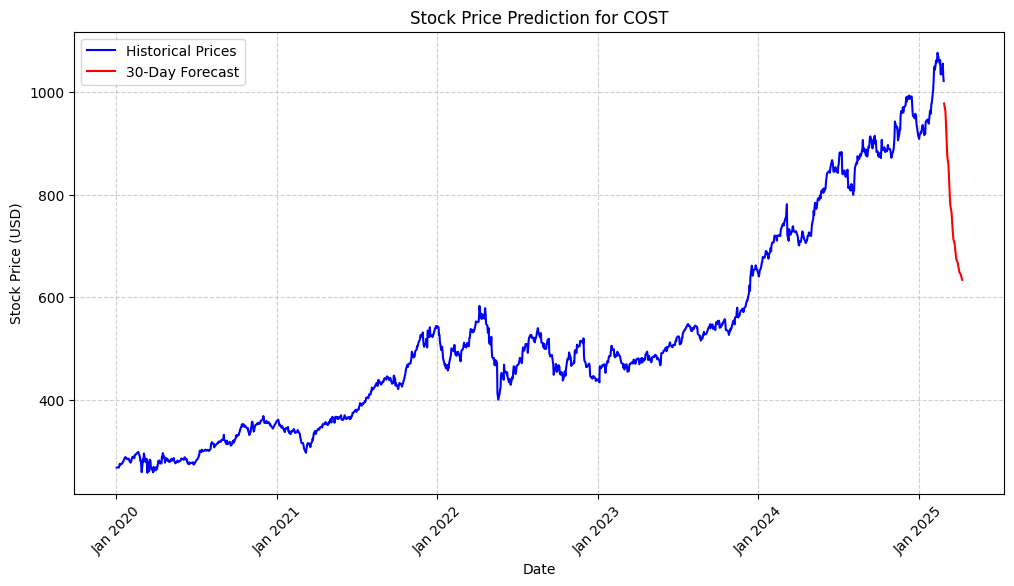

In [11]:
# Step 9: Visualize the Results

import matplotlib.dates as mdates

# Generate future dates (business days only)
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Create a DataFrame to hold forecasted prices with corresponding dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Prediction': future_predictions})
forecast_df.set_index('Date', inplace=True)

# Plot historical data and future predictions
plt.figure(figsize=(12, 6))

# Plot historical prices (blue)
plt.plot(data.index, data['Close'], label='Historical Prices', color='blue')

# Plot forecasted prices as a **solid red line**
plt.plot(forecast_df.index, forecast_df['Prediction'], label='30-Day Forecast', color='red')  

# Improve date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates as "Jan 2024"
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Add labels, title, and grid
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.title(f"Stock Price Prediction for {ticker}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid readability

# Show the plot
plt.show()





In [12]:
import os
from sklearn.metrics import mean_squared_error

# Step 10: Model Accuracy Check

# Ensure the "graphs" folder exists
graph_folder = "graphs"
os.makedirs(graph_folder, exist_ok=True)

# Define test data (last 20% of historical data)
test_data = scaled_data[training_data_len - 60:]  # Include last 60 days for proper sequence

# Create x_test and y_test
x_test = np.array([test_data[i-60:i, 0] for i in range(60, len(test_data))])
y_test = np.array([test_data[i, 0] for i in range(60, len(test_data))])

# Reshape x_test to match LSTM input shape
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Make predictions on the test set
predictions = model.predict(x_test)

# Convert predictions and actual values back to original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Print accuracy results
print(f"Model RMSE: {rmse:.2f} (Lower is better)")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label="Actual Prices", color='blue')
plt.plot(data.index[-len(y_test):], predictions, label="Predicted Prices", color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.title(f"Model Accuracy Check for {ticker}\nRMSE: {rmse:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Save the graph with RMSE info
accuracy_graph_path = f"{graph_folder}/{ticker}_accuracy.png"
plt.savefig(accuracy_graph_path)
plt.close()

print(f"Accuracy Graph saved: {accuracy_graph_path} ✅")

# Save RMSE value separately for website display
rmse_file_path = f"{graph_folder}/{ticker}_rmse.txt"
with open(rmse_file_path, "w") as f:
    f.write(f"{rmse:.2f}")

print(f"RMSE saved: {rmse_file_path} ✅")



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
Model RMSE: 33.41 (Lower is better)
Accuracy Graph saved: graphs/COST_accuracy.png ✅
RMSE saved: graphs/COST_rmse.txt ✅


In [13]:
# Ensure forecast exists before using it
if 'future_predictions' not in locals():
    raise ValueError("Error: 'future_predictions' is not defined. Ensure predictions are generated before plotting.")

# Convert predictions into a DataFrame
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Prediction': future_predictions})
forecast_df.set_index('Date', inplace=True)

# Ensure folder exists to store graphs
graph_folder = "graphs"
os.makedirs(graph_folder, exist_ok=True)

# Generate a plot
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Historical Prices', color='blue')  # Plot historical data
plt.plot(forecast_df.index, forecast_df['Prediction'], label='30-Day Forecast', color='red')  # Forecasted prices

# Customize the graph
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.title(f"Stock Price Prediction for {ticker}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Save the graph
graph_path = f"{graph_folder}/{ticker}.png"
plt.savefig(graph_path)
plt.close()

print(f"Graph saved: {graph_path} ✅")


Graph saved: graphs/COST.png ✅


In [14]:
# Calculate Moving Averages
data["MA7"] = data["Close"].rolling(window=7).mean()
data["MA21"] = data["Close"].rolling(window=21).mean()

# Plot with Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Close"], label="Stock Price", color='blue')
plt.plot(data.index, data["MA7"], label="7-Day MA", color='orange')
plt.plot(data.index, data["MA21"], label="21-Day MA", color='green')

plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title(f"{ticker} Stock Price with Moving Averages")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Save Graph
moving_avg_path = f"{graph_folder}/{ticker}_moving_avg.png"
plt.savefig(moving_avg_path)
plt.close()
